<a href="https://colab.research.google.com/github/tangshuting/daytoy/blob/master/cleverhans_MIFGSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans

  Cloning https://github.com/tensorflow/cleverhans.git to /tmp/pip-install-g7yyb2ao/cleverhans
  Running command git clone -q https://github.com/tensorflow/cleverhans.git /tmp/pip-install-g7yyb2ao/cleverhans
     |████████████████████████████████| 163kB 2.8MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
  Created wheel for cleverhans: filename=cleverhans-3.0.1-cp36-none-any.whl size=262573 sha256=14e1c0adb134e4b03719fd08ad83943a63f4ed235068c596b530389e74d6f719
  Stored in directory: /tmp/pip-ephem-wheel-cache-vyf2ce3u/wheels/6e/59/ec/723a6f654aaf62c8c40f0f0850fdf71a4948598697f56c3bfa
Successfully built cleverhans


In [ ]:
import cleverhans
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive')
f = open(r'/content/drive/My Drive/EMW/2016.04C.multisnr.pkl','rb') #open的参数是pkl文件的路径
Xd = pickle.load(f,encoding='bytes')
print(type(Xd))   # dict
print(len(Xd))  #220=11（类别）×20（20个snr）
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])  # set()创建一个无序的不重复元素序列
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr)) # append末尾添加对象
X = np.vstack(X)

np.random.seed(2016)
n_examples = X.shape[0]  # int 162060
n_train = n_examples * 0.5
train_idx = np.random.choice(range(0,n_examples), size= int(n_train), replace=False)  # ndarray with shape (81030,)
test_idx = list(set(range(0,n_examples))-set(train_idx))   # list (81030 items total)

X_train = X[train_idx]  # ndarray with shape (81030, 2, 128)
X_test =  X[test_idx]   # 同上
print(X_train.shape)

# print(lbl.shape) # AttributeError: 'list' object has no attribute 'shape' 解决办法是使用vstack函数
lbl_no = np.vstack(lbl)  # 这一步骤没必要，因为可以直接使用lbl去取出来调制方式
print(lbl_no)  # ndarray with shape (162060, 2)  [b'8PSK' b'-20']

lbl_mods = lbl_no[0]
print(lbl_mods)

Y_train_no = list(map(lambda x: mods.index(lbl[x][0]), train_idx))  # 显示的是1-11数字表示调制方式list (81030 items total)
print(Y_train_no[1])
Y_train_no = np.vstack(Y_train_no)  # # ndarray with shape (81030, 1)

Y_test_no = list(map(lambda x: mods.index(lbl[x][0]), test_idx))  
Y_test_no = np.vstack(Y_test_no) 


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
<class 'dict'>
220
(81030, 2, 128)
[[b'8PSK' b'-20']
 [b'8PSK' b'-20']
 [b'8PSK' b'-20']
 ...
 [b'WBFM' b'18']
 [b'WBFM' b'18']
 [b'WBFM' b'18']]
[b'8PSK' b'-20']
10


In [ ]:
Y_train_mod = lbl_no[:,0]
Y_train_mod_vsatck = np.vstack(Y_train_mod)  # 字幕显示调制方式
print(Y_train_mod_vsatck)

Y_train_snrs = list(map(lambda x: snrs.index(lbl[x][1]), train_idx))
# print(Y_train_snrs)
Y_train_snrs = np.vstack(Y_train_snrs)  
Y_test_snrs = list(map(lambda x: snrs.index(lbl[x][1]), test_idx))
print(Y_test_snrs[1])
Y_test_snrs = np.vstack(Y_test_snrs) 

[[b'8PSK']
 [b'8PSK']
 [b'8PSK']
 ...
 [b'WBFM']
 [b'WBFM']
 [b'WBFM']]
5


In [ ]:
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))  # ndarray with shape (81030, 11)

In [ ]:
in_shp = list(X_train.shape[1:])   # list [2, 128]

classes = mods  # list [b'8PSK', b'AM-DSB', b'AM-SSB', b'BPSK', b'CPFSK', b'GFSK', b'PAM4', b'QAM16', b'QAM64', b'QPSK', b'WBFM'] (11 items total)

mods_str = []
for i in mods:
  mods_str.append(str(i).split('\'')[1])
print(mods_str)   # list ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
# print(Y_train[1])  # [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
# print(Y_train.shape)  # ndarray with shape (81030, 11)

['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']


In [ ]:
num_classes = 11

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_shape=in_shp),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(135,activation=tf.nn.relu),
    tf.keras.layers.Dense(11),
    tf.keras.layers.Activation(tf.nn.softmax) # We seperate the activation layer to be able to access the logits of the previous layer later
])

model.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

nb_epoch = 100    # number of epochs to train on
batch_size = 1024  # training batch size
model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=2, validation_split=0.2)
# model.fit(X_train, Y_train,  epochs=nb_epoch, verbose=2, validation_split=0.2)

test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2, 128)            16512     
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 135)               69255     
_________________________________________________________________
dense_3 (Dense)              (None, 11)                1496      
_________________________________________________________________
activation (Activation)      (None, 11)                0

In [ ]:
# Import the attack
from cleverhans.future.tf2.attacks import momentum_iterative_method

#The attack requires the model to ouput the logits
logits_model = tf.keras.Model(model.input,model.layers[-1].output)

In [ ]:
random_index = 3
print(Y_test[random_index],Y_test_no[random_index],Y_test_snrs[random_index])

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] [8] [5]


In [ ]:
# 现在是随机选择一个无线电信号，后面重新固定SNR和调制方式进行选择
# random_index = np.random.randint(X_test.shape[0])
# print(lbl_no[random_index])

original_image = X_test[random_index] # EagerTensor with shape (1, 2, 128)
original_image = tf.convert_to_tensor(original_image.reshape((1,2,128))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor

original_label = Y_test_no[random_index]
original_label = np.reshape(original_label, (1,)).astype('int64')

In [ ]:

adv_example_untargeted_label = momentum_iterative_method(logits_model, original_image, eps=0.8, eps_iter=0.05, nb_iter=10, norm=np.inf,
                               clip_min=None, clip_max=None, y=None, targeted=False,
                               decay_factor=1.0, sanity_checks=True)
# eps = 2
# eps_iter = 0.05
# nb_iter = 10
# decay_factor=1.0
# adv_example_untargeted_label = momentum_iterative_method(logits_model, original_image, eps, eps_iter, nb_iter, norm=np.inf,
#                                clip_min=None, clip_max=None, y=None, targeted=False,
#                                decay_factor, sanity_checks=True)
example_untargeted_pred = model.predict(original_image) 
adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)  # ndarray with shape (1, 11) 给出了11个概率
# print(adv_example_untargeted_label.shape)
print(np.argmax(example_untargeted_pred),example_untargeted_pred)
print(np.argmax(adv_example_untargeted_label_pred),adv_example_untargeted_label_pred)



8 [[7.2873995e-04 6.4036549e-06 7.1645346e-08 8.5878588e-04 6.0889719e-04
  3.5920621e-05 4.2272687e-02 4.0763804e-01 5.4196072e-01 5.8666687e-03
  2.3049937e-05]]
4 [[0.06840288 0.05580281 0.09104174 0.13371775 0.17583415 0.13322504
  0.09448635 0.05580385 0.02306948 0.09390389 0.07471202]]


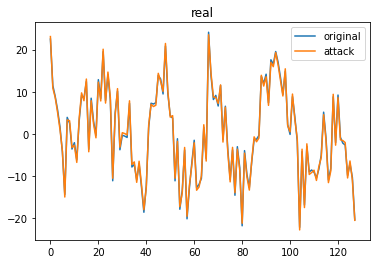

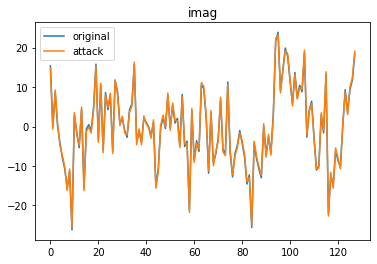

In [ ]:
original_image_plt = np.reshape(original_image, (2,128))
real = original_image_plt[0]  #取（2，128）的行
imag = original_image_plt[1]

adv_example_untargeted_label_plt = np.reshape(adv_example_untargeted_label, (2,128))
real_adv = adv_example_untargeted_label_plt[0]  #取（2，128）的行
imag_adv = adv_example_untargeted_label_plt[1]
# plt.plot(real_adv,label='real_adv')
# plt.plot(imag_adv,label='imag_adv')
# plt.title("Model Prediction: {}".format(np.argmax(adv_example_untargeted_label_pred)))
# plt.xlabel("Original Label: {}".format(original_label[0]))
# plt.legend()  #设置 legend 图例
# plt.show()


plt.figure()
plt.plot(real,label='original')
plt.plot(real_adv,label='attack')
plt.title("real")
plt.legend()  #设置 legend 图例
plt.figure()
plt.plot(imag,label='original')
plt.plot(imag_adv,label='attack')
plt.title("imag")
plt.legend()  #设置 legend 图例

In [ ]:
# 均方根误差
x1 = original_image_plt
x2 = adv_example_untargeted_label_plt
# print(x1,x2)
x1_2 = x1 - x2
# print(x1_2)
x1_2_2 = np.multiply(x1_2,x1_2)  # 矩阵对应元素相乘就相当于各个元素平方
# print(x1_2_2.shape)
x1_2_2_sum = x1_2_2.sum(axis=1)  # axis=1求行和
x1_2_2_sum_chu = x1_2_2_sum / 128
# print(x1_2_2_sum,x1_2_2_sum_chu)
# print(x1_2_sum,abs(x1_2_sum))
x_sqrt = np.sqrt(x1_2_2_sum_chu)
print(x_sqrt) 

[0.5711838 0.5837491]


In [ ]:
x1 = original_image_plt
x2 = adv_example_untargeted_label_plt
x1_2 = x1 - x2
x1_2_sum = x1_2.sum(axis=1)/128
print(x1_2_sum,abs(x1_2_sum))
x_sqrt = np.sqrt(abs(x1_2_sum))
print(x_sqrt) 

[ 0.05812521 -0.01218756] [0.05812521 0.01218756]
[0.24109171 0.11039728]
